In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import os
from datetime import datetime
import random
import string
import multiprocessing as mp
import itertools

In [2]:
import matplotlib.pyplot as plt
import timeit
%load_ext memory_profiler


In [3]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [4]:
REWARD = 100

In [5]:
seed = 4507
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

env = gym.make('CartPole-v0')
XTRA_FEAT   = 0 #masscart, masspole, length
N_ACTIONS   = env.action_space.n
N_STATES    = env.observation_space.shape[0]  +  XTRA_FEAT 
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

In [6]:
RNDM_STRING = ''.join(random.choices(string.ascii_uppercase + string.digits, k=8)) + datetime.now().strftime("_%H_%M_%S")
print("ID: ",RNDM_STRING)
MODEL_FILENAME = './models/'+ RNDM_STRING + "_NN" + ".pt"
print("NN-MODEL FILENAME: ", MODEL_FILENAME)

ID:  U7QE8IKW_23_20_40
NN-MODEL FILENAME:  ./models/U7QE8IKW_23_20_40_NN.pt


In [7]:
def ndim_grid(start,stop, granularity):
    # Set number of dimensions
    ndims = len(start)

    # List of ranges across all dimensions
    L = [np.linspace(start[i],stop[i],granularity[i]) for i in range(ndims)]

    # Finally use meshgrid to form all combinations corresponding to all 
    # dimensions and stack them as M x ndims array
    return np.hstack((np.meshgrid(*L))).swapaxes(0,1).reshape(ndims,-1).T

In [8]:
def discretize(value, borders):
    c_pos_val, c_vel_val, p_ang_val, p_vel_val   = value
    c_pos_s  , c_vel_s  ,p_ang_s   , p_vel_s     = borders
    
    indx = np.empty_like(value).astype(np.intp)
    
    for i in range(value.shape[0]):
        if value[i] > borders[i].max():
            indx[i] = borders[i].argmax().astype(np.intp)
        else:
            indx[i] = np.where(borders[i] >= value[i])[0][0].astype(np.intp)
    return indx



In [9]:
T_LR           = 1e-2
T_GAMMA        = 0.99
T_EPSILON      = 0.98

NO_OF_NODES    = 10
NO_OF_EPISODES = 100
TIMESTEP_LIMIT = 200

print("Number of NODES: ", NO_OF_NODES)
print("Number of EPISODES per NODE", NO_OF_EPISODES)

Number of NODES:  10
Number of EPISODES per NODE 100


In [10]:
# Hyper Parameters
HIDDEN_LAYER        = 50
BATCH_SIZE          = 32
NN_LR               = 1e-3  # learning rate
NN_GAMMA            = 0.9   # reward discount
TARGET_REPLACE_ITER = 500   # target update frequency
MIN_MEMORY_CAP      = 200000

In [11]:
MAX_NO_OF_ITERATIONS = 50
MAX_NN_ITERATIONS    = 50000
print("Number of ITERATIONS: ",MAX_NO_OF_ITERATIONS)

Number of ITERATIONS:  50


In [12]:
# class Net(nn.Module):
#     def __init__(self, ):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(N_STATES, 50)
#         nn.init.kaiming_uniform_(self.fc1.weight)   # initialization
#         self.out = nn.Linear(50, N_ACTIONS)
#         nn.init.xavier_uniform_(self.out.weight)   # initialization

#     def forward(self, x):
#         x = self.fc1(x)
#         x = F.relu(x)
#         actions_value = self.out(x)
#         return actions_value

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        nn.init.kaiming_uniform_(self.fc1.weight)

        self.adv = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        nn.init.xavier_uniform_(self.adv.weight) 
    
        self.val = nn.Linear(HIDDEN_LAYER, 1)
        nn.init.xavier_uniform_(self.val.weight)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        adv = self.adv(x)
        val = self.val(x)
        
        return val + adv - adv.mean()
    
class D3QN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()

        self.learn_step_counter  = 0 # for target updating
        
        self.memory_counter      = 0
        self.memory              = np.zeros((int(MIN_MEMORY_CAP), N_STATES * 2 + 2)) # initialize memory
        
#         self.good_memory_counter = 0 # for storing non-terminal memories
#         self.good_memory         = np.zeros((MIN_MEMORY_CAP ,N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
#         self.bad_memory_counter  = 0 # for storing terminal memories
#         self.bad_memory          = np.zeros((MIN_MEMORY_CAP , N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        self.running_loss        = 0
        self.optimizer           = torch.optim.Adam(self.eval_net.parameters(), lr=NN_LR)
        self.loss_func           = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action
    
    def get_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions = self.eval_net.forward(x).view(-1,N_ACTIONS).max(1)[1].data.numpy().astype(np.intp)
#         actions_value 
#         action = torch.max(actions_value, 1)[1].data.numpy()
#         action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return actions
    
    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.data.numpy().astype(np.float16)
        return actions_value

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1
        
        sample_index_limit = min(MIN_MEMORY_CAP, self.memory_counter)
        sample_index = np.random.choice(int(sample_index_limit),int(BATCH_SIZE))
        b_memory = self.memory[sample_index,:]
#         # sample batch transitions
#         good_sample_index_limit = min(MIN_MEMORY_CAP, self.good_memory_counter)
#         bad_sample_index_limit = min(MIN_MEMORY_CAP, self.bad_memory_counter)

#         good_sample_index = np.random.choice(int(good_sample_index_limit), int(BATCH_SIZE-int(BATCH_SIZE*TERMINAL_BIAS)))
#         bad_sample_index  = np.random.choice(int(bad_sample_index_limit),  int(BATCH_SIZE*TERMINAL_BIAS))

#         b_good_memory = self.good_memory[good_sample_index, :]
#         b_bad_memory  = self.bad_memory[bad_sample_index, :]
#         b_memory      = np.vstack((b_good_memory,b_bad_memory))
        
        b_s  = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a  = torch.LongTensor( b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r  = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        a_eval   = self.eval_net(b_s).max(1)[1].view(BATCH_SIZE, 1) #best action according to eval_net
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + NN_GAMMA * q_next.gather(1, a_eval)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.running_loss += loss.mean().item()
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            print('LOSS : %.3f' %(self.running_loss / TARGET_REPLACE_ITER), end="\t")
            self.running_loss = 0.0

In [13]:
def clamp(MIN_VAL, VAL, MAX_VAL):
    return max(MIN_VAL, min(VAL, MAX_VAL))

In [14]:
# ABSOLUTE LIMITS ON STATE VALUES
C_POS_ABS_MAX =  2.6
C_POS_ABS_MIN = -2.6

C_VEL_ABS_MAX =  5
C_VEL_ABS_MIN = -5

P_ANG_ABS_MAX =  0.25
P_ANG_ABS_MIN = -0.25

P_VEL_ABS_MAX =  6
P_VEL_ABS_MIN = -6

In [15]:
# SET GRANULARITY
HI_GRAIN = 40
print("HI_GRAIN = ", HI_GRAIN)

HI_GRAIN =  40


In [16]:
def mp_node_run(node_id, boundary, iteration, node_q_table):

    # SET SEED
    ###############################################
    my_seed = seed + node_id + iteration
    random.seed(my_seed)
    torch.manual_seed(my_seed)
    np.random.seed(my_seed)
    os.environ['PYTHONHASHSEED'] = str(my_seed)
    my_env = env
    my_env.seed(my_seed)
    ###############################################


    # CREATE STATE TABLE BORDERS
    ###############################################
    c_pos_s  = np.linspace(C_POS_ABS_MIN,  C_POS_ABS_MAX,  HI_GRAIN)
    c_vel_s  = np.linspace(C_VEL_ABS_MIN,  C_VEL_ABS_MAX,  HI_GRAIN)
    p_ang_s  = np.linspace(P_ANG_ABS_MIN,  P_ANG_ABS_MAX,  HI_GRAIN)
    p_vel_s  = np.linspace(P_VEL_ABS_MIN,  P_VEL_ABS_MAX,  HI_GRAIN)

    borders = [c_pos_s, c_vel_s, p_ang_s, p_vel_s]
    ###############################################
    
    my_Q_TABLE = node_q_table

    time_rec                = np.zeros(NO_OF_EPISODES)
    level_up_flag           = False
    PERFECT_RUN_COUNTER     = 10
    PERFECT_RUNS_HIGH_SCORE = 10
    level_up_metric         = 195

    exp_rec      = np.empty(N_STATES * 2 + 2)
    
#     if iteration < 3:
    my_EPSILON   = np.clip(((3%5 + 1)*0.1 + (iteration)*0.2) ,0.4,0.98)+ np.random.uniform(-0.01,0.01)
#     print(node_id, my_EPSILON)
#     else:
#         my_EPSILON   = T_EPSILON + np.random.uniform(-0.01,0.01)
    
    while True:
        i_episode = 0
        
        while i_episode < NO_OF_EPISODES:
            ep_exp_rec = np.empty(N_STATES * 2 + 2)
            time_steps = 0
            
            s = my_env.reset()
            
            while True:
                time_steps += 1
                
                #get state
                this_state = tuple(discretize(s, borders))
                
                # choose action
                if np.random.uniform() > my_EPSILON:   # greedy
                    a = np.random.randint(0, N_ACTIONS)
                else:
                    a = my_Q_TABLE[this_state]

                 # take action
                s_, r, done, info = my_env.step(a)

                if done:
                    r = -REWARD
                    if time_steps >= TIMESTEP_LIMIT:
                        r = REWARD
                
                #store experience
                experience = np.hstack((s,a,r,s_))
                exp_rec = np.vstack((exp_rec, experience))

                #discretize next_state
                next_state = tuple(discretize(s_, borders))
                
                if done or time_steps >= TIMESTEP_LIMIT:
                    time_rec[i_episode] = time_steps
                    break
                s = s_

            i_episode += 1
        if i_episode >= NO_OF_EPISODES:
            i_episode = 0
            break

    exp_rec = np.delete(exp_rec, 0, 0)
#         message = "NODE#"+str(node_id) +" MAIN Q:"+ str(new_Q_TABLE.mean()) +"\t" + "NODE Q:" + str(my_Q_TABLE.mean())
#         print(message)
    
    # GET NEW STATE BOUNDARIES: +/- 25% of experienced state
    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX] = [exp_rec[:,i].max() for i in range(N_STATES)]
    [C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN] = [exp_rec[:,i].min() for i in range(N_STATES)]

    newboundary = [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX,
                   C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN]
    
    return exp_rec, time_rec, newboundary

In [17]:
total_serial_timesteps   = 0
total_parallel_timesteps = 0

In [18]:
iteration = 0
# my_dqn = D3QN()
dqn = D3QN()

# INITIALIZE BOUNDARY TO MAXIMUM VALUES
init_node_boundary = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX,
                      C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN]



# CREATE STATE COMBINATIONS
# ###############################################

init_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN],
                                    [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX],
                                    [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN])



# # GET Q-VALUES 
start = timeit.default_timer()
%memit init_q_table = dqn.get_greedy_action(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN).astype(np.intp)
stop = timeit.default_timer()
print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    
# SAVE QFILE
# node_QFILE = './Q_NPY/' + RNDM_STRING + 'QFILE' + ".npy"
# np.save(node_QFILE, init_q_table)

peak memory: 1256.62 MiB, increment: 1036.50 MiB
Quantization TIME:  0.01 minutes


In [19]:
# ENVIRONMENT FOR CHECKING NN MODEL
v_env = gym.make('CartPole-v0')
v_env.seed(seed*2)

# CREATE A POOL OF PROCESSES
pool = mp.Pool(NO_OF_NODES)

# SET INITIAL NODE BOUDNARIES FOR ALL NODES
node_boundaries = [init_node_boundary] * NO_OF_NODES
node_q_table = init_q_table



ITERATION # 0
TOTAL EXPERIENCE GENERATED:   15246
SMALLEST TIMESTEP: 8
LARGEST  TIMESTEP: 66
TOTAL SERIAL TIMESTEPS:   15246
TOTAL PARALLEL TIMESTEPS: 66


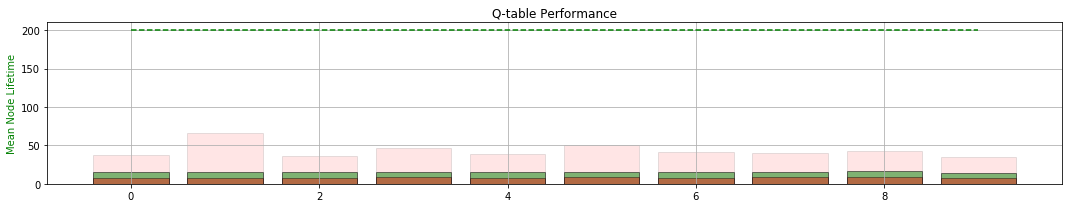

MEMORY COUNTER:  15246
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 555.727	LOSS : 522.889	LOSS : 513.938	LOSS : 499.048	LOSS : 493.776	LOSS : 469.545	LOSS : 471.184	LOSS : 455.996	LOSS : 458.138	LOSS : 463.686	LOSS : 422.999	LOSS : 436.475	LOSS : 415.938	LOSS : 408.353	LOSS : 432.155	LOSS : 418.315	LOSS : 427.854	LOSS : 391.653	LOSS : 403.354	LOSS : 388.886	
Validating... MEAN TIME:  100.755
LOSS : 382.654	LOSS : 383.664	LOSS : 372.875	LOSS : 391.160	LOSS : 379.716	LOSS : 379.026	LOSS : 361.825	LOSS : 366.439	LOSS : 381.891	LOSS : 375.686	LOSS : 367.827	LOSS : 373.536	LOSS : 364.466	LOSS : 373.488	LOSS : 372.732	LOSS : 382.166	LOSS : 383.971	LOSS : 378.469	LOSS : 393.015	LOSS : 382.418	
Validating... MEAN TIME:  125.075
LOSS : 392.849	LOSS : 396.321	LOSS : 382.431	LOSS : 392.606	LOSS : 412.646	LOSS : 412.715	LOSS : 404.247	LOSS : 411.626	LOSS : 425.403	LOSS : 433.893	LOSS : 416.923	LOSS : 427.775	LOSS : 442.788	LOSS : 452.308	LOSS : 447.226	LOSS : 443.724	LOSS : 4

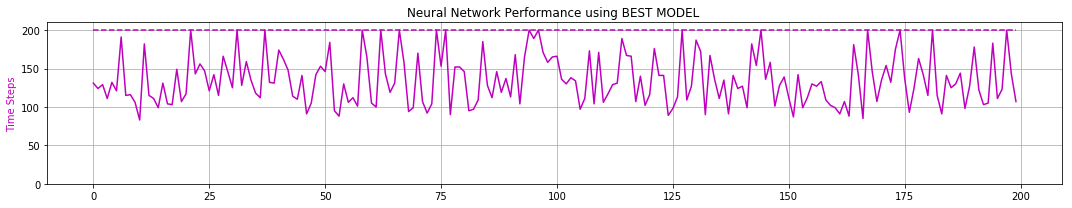

peak memory: 1322.74 MiB, increment: 1044.48 MiB
0 -max- [ 0.142  0.824  0.209  3.108]
0 -min- [-0.292 -2.461 -0.204 -1.287]

1 -max- [ 0.106  1.335  0.209  2.983]
1 -min- [-0.596 -2.321 -0.174 -2.096]

2 -max- [ 0.117  0.827  0.209  2.749]
2 -min- [-0.271 -2.089 -0.148 -1.161]

3 -max- [ 0.158  0.993  0.209  2.727]
3 -min- [-0.372 -1.763 -0.208 -1.513]

4 -max- [ 0.151  1.416  0.208  2.738]
4 -min- [-0.463 -1.973 -0.207 -2.197]

5 -max- [ 0.133  1.398  0.209  2.739]
5 -min- [-0.330 -1.786 -0.209 -2.228]

6 -max- [ 0.187  0.939  0.209  2.913]
6 -min- [-0.273 -2.336 -0.194 -1.611]

7 -max- [ 0.145  1.017  0.209  2.949]
7 -min- [-0.298 -2.133 -0.208 -1.760]

8 -max- [ 0.167  1.003  0.209  2.886]
8 -min- [-0.451 -1.966 -0.206 -1.486]

9 -max- [ 0.173  1.153  0.209  2.715]
9 -min- [-0.300 -1.765 -0.196 -1.708]

Quantization TIME:  0.01 minutes


ITERATION # 1
TOTAL EXPERIENCE GENERATED:   107447
SMALLEST TIMESTEP: 9
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   122693
TOTAL PARALLEL TIM

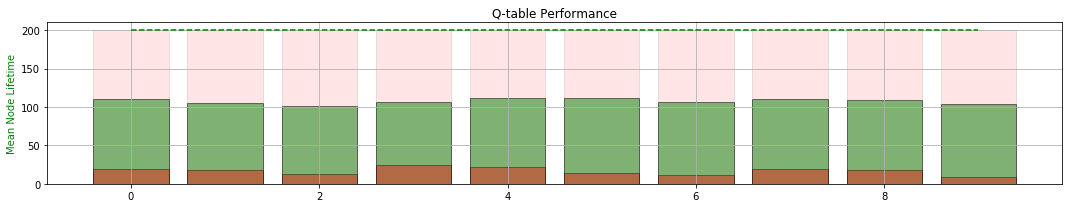

MEMORY COUNTER:  122693
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 628.894	LOSS : 622.281	LOSS : 598.211	LOSS : 557.073	LOSS : 529.450	LOSS : 474.840	LOSS : 464.480	LOSS : 422.050	LOSS : 398.706	LOSS : 370.644	LOSS : 363.615	LOSS : 330.064	LOSS : 331.521	LOSS : 307.203	LOSS : 313.204	LOSS : 304.211	LOSS : 286.505	LOSS : 310.356	LOSS : 269.070	LOSS : 288.672	
Validating... MEAN TIME:  87.88
LOSS : 303.956	LOSS : 274.072	LOSS : 289.001	LOSS : 271.697	LOSS : 301.910	LOSS : 275.768	LOSS : 272.839	LOSS : 277.122	LOSS : 264.302	LOSS : 280.913	LOSS : 280.822	LOSS : 281.401	LOSS : 274.362	LOSS : 276.201	LOSS : 283.674	LOSS : 290.977	LOSS : 271.359	LOSS : 288.166	LOSS : 300.926	LOSS : 281.817	
Validating... MEAN TIME:  127.595
LOSS : 291.452	LOSS : 297.988	LOSS : 268.758	LOSS : 289.456	LOSS : 272.284	LOSS : 307.680	LOSS : 300.044	LOSS : 293.556	LOSS : 280.737	LOSS : 280.335	LOSS : 313.162	LOSS : 300.883	LOSS : 306.123	LOSS : 318.061	LOSS : 311.071	LOSS : 306.918	LOSS : 33

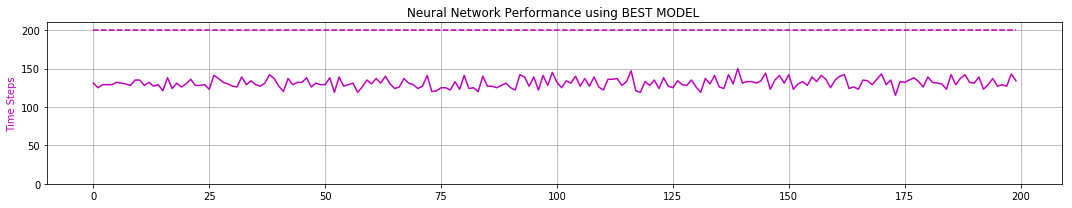

peak memory: 1381.57 MiB, increment: 1032.64 MiB
0 -max- [ 1.232  2.669  0.209  2.054]
0 -min- [-1.010 -1.848 -0.209 -3.320]

1 -max- [ 1.077  2.533  0.209  2.208]
1 -min- [-0.805 -1.511 -0.209 -3.168]

2 -max- [ 1.177  2.919  0.209  2.114]
2 -min- [-0.761 -1.697 -0.209 -3.413]

3 -max- [ 1.099  2.927  0.209  1.460]
3 -min- [-0.854 -1.694 -0.209 -3.303]

4 -max- [ 0.993  2.053  0.209  2.026]
4 -min- [-1.013 -1.709 -0.209 -2.474]

5 -max- [ 1.090  2.265  0.209  1.835]
5 -min- [-0.787 -1.700 -0.209 -2.904]

6 -max- [ 1.254  2.679  0.209  1.766]
6 -min- [-0.748 -1.322 -0.209 -3.002]

7 -max- [ 1.090  2.482  0.209  1.737]
7 -min- [-0.746 -1.657 -0.209 -3.312]

8 -max- [ 1.135  3.042  0.209  2.037]
8 -min- [-0.765 -1.710 -0.209 -3.504]

9 -max- [ 0.990  2.649  0.209  1.862]
9 -min- [-0.853 -1.680 -0.209 -3.246]

Quantization TIME:  0.01 minutes


ITERATION # 2
TOTAL EXPERIENCE GENERATED:   145559
SMALLEST TIMESTEP: 11
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   268252
TOTAL PARALLEL TI

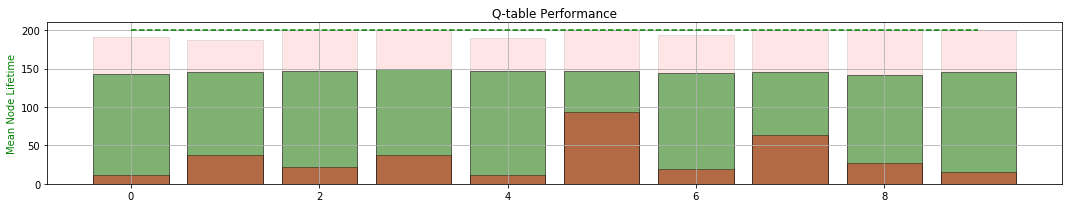

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 181.836	LOSS : 180.451	LOSS : 178.987	LOSS : 161.525	LOSS : 151.325	LOSS : 152.059	LOSS : 164.428	LOSS : 161.131	LOSS : 156.399	LOSS : 141.613	LOSS : 147.692	LOSS : 135.634	LOSS : 136.652	LOSS : 123.974	LOSS : 139.216	LOSS : 122.518	LOSS : 126.655	LOSS : 132.262	LOSS : 126.241	LOSS : 127.771	
Validating... MEAN TIME:  151.43
LOSS : 115.245	LOSS : 118.481	LOSS : 120.654	LOSS : 111.045	LOSS : 113.639	LOSS : 110.672	LOSS : 112.060	LOSS : 113.624	LOSS : 98.581	LOSS : 97.823	LOSS : 111.121	LOSS : 105.098	LOSS : 101.795	LOSS : 109.284	LOSS : 103.645	LOSS : 89.378	LOSS : 101.557	LOSS : 95.403	LOSS : 96.787	LOSS : 100.584	
Validating... MEAN TIME:  150.965
LOSS : 99.107	LOSS : 94.343	LOSS : 96.383	LOSS : 92.006	LOSS : 88.548	LOSS : 96.262	LOSS : 101.604	LOSS : 88.795	LOSS : 97.083	LOSS : 96.797	LOSS : 87.715	LOSS : 90.689	LOSS : 92.216	LOSS : 100.773	LOSS : 87.968	LOSS : 91.255	LOSS : 94.578	LOSS : 89.491

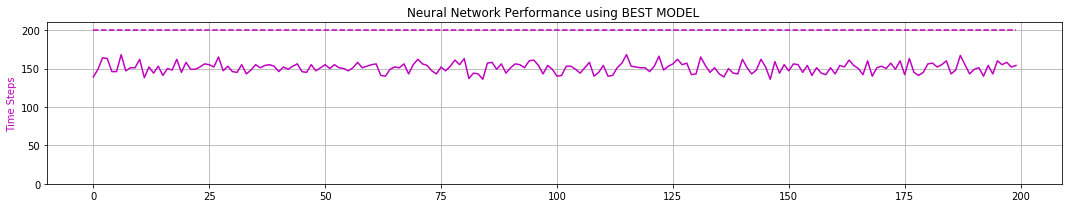

peak memory: 1409.04 MiB, increment: 1037.18 MiB
0 -max- [ 2.400  3.170  0.208  1.929]
0 -min- [-0.129 -1.210 -0.137 -1.859]

1 -max- [ 2.399  3.168  0.206  2.213]
1 -min- [-0.142 -0.961 -0.204 -1.838]

2 -max- [ 2.399  3.383  0.209  1.608]
2 -min- [-0.120 -1.169 -0.209 -2.094]

3 -max- [ 2.400  3.191  0.209  1.783]
3 -min- [-0.150 -1.140 -0.144 -1.855]

4 -max- [ 2.400  3.168  0.208  1.932]
4 -min- [-0.138 -0.828 -0.206 -2.145]

5 -max- [ 2.400  3.153  0.209  1.618]
5 -min- [-0.165 -0.980 -0.178 -2.138]

6 -max- [ 2.399  3.206  0.208  1.913]
6 -min- [-0.136 -0.948 -0.081 -1.880]

7 -max- [ 2.400  3.218  0.209  1.563]
7 -min- [-0.120 -1.168 -0.128 -1.829]

8 -max- [ 2.400  2.955  0.208  1.749]
8 -min- [-0.149 -0.952 -0.095 -1.609]

9 -max- [ 2.400  3.204  0.207  2.130]
9 -min- [-0.139 -1.155 -0.201 -1.875]

Quantization TIME:  0.01 minutes


ITERATION # 3
TOTAL EXPERIENCE GENERATED:   189232
SMALLEST TIMESTEP: 151
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   457484
TOTAL PARALLEL T

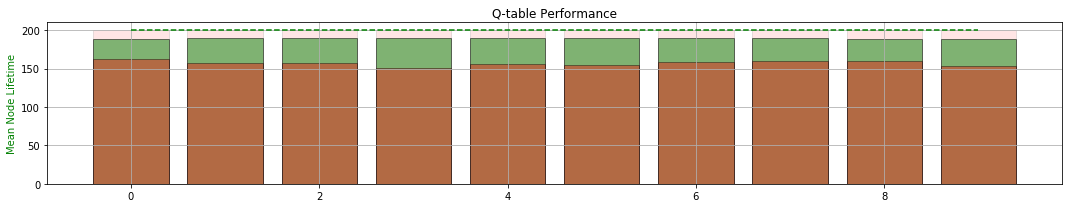

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 56.297	LOSS : 55.917	LOSS : 53.193	LOSS : 47.185	LOSS : 57.816	LOSS : 47.035	LOSS : 53.399	LOSS : 54.639	LOSS : 49.742	LOSS : 55.888	LOSS : 47.775	LOSS : 57.360	LOSS : 63.350	LOSS : 66.263	LOSS : 52.017	LOSS : 48.558	LOSS : 53.540	LOSS : 58.006	LOSS : 51.622	LOSS : 53.776	
Validating... MEAN TIME:  173.915
LOSS : 51.043	LOSS : 50.450	LOSS : 59.771	LOSS : 52.355	LOSS : 45.082	LOSS : 54.234	LOSS : 48.980	LOSS : 54.102	LOSS : 49.280	LOSS : 49.987	LOSS : 48.709	LOSS : 53.990	LOSS : 51.682	LOSS : 52.579	LOSS : 58.084	LOSS : 47.982	LOSS : 53.064	LOSS : 50.189	LOSS : 57.091	LOSS : 61.566	
Validating... MEAN TIME:  111.85
LOSS : 48.782	LOSS : 53.241	LOSS : 53.119	LOSS : 58.681	LOSS : 54.883	LOSS : 44.873	LOSS : 47.405	LOSS : 59.694	LOSS : 51.253	LOSS : 48.754	LOSS : 55.776	LOSS : 52.239	LOSS : 45.389	LOSS : 46.988	LOSS : 53.041	LOSS : 42.555	LOSS : 51.958	LOSS : 53.782	LOSS : 47.019	LOSS : 46.730	
Validat

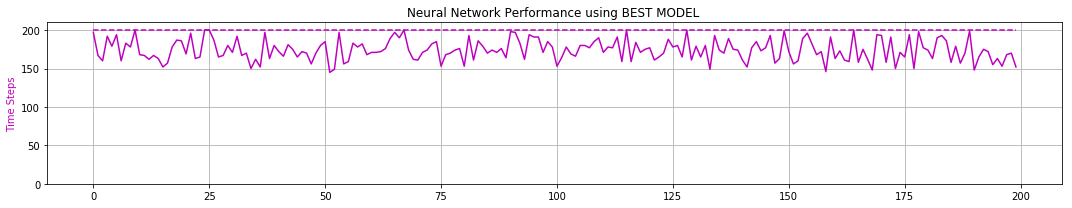

peak memory: 1441.24 MiB, increment: 964.43 MiB
0 -max- [ 2.400  2.179  0.141  1.354]
0 -min- [-0.136 -0.780 -0.071 -1.332]

1 -max- [ 2.399  2.178  0.151  1.357]
1 -min- [-0.127 -0.776 -0.070 -1.025]

2 -max- [ 2.400  2.185  0.170  1.379]
2 -min- [-0.135 -0.789 -0.054 -1.292]

3 -max- [ 2.400  2.178  0.135  1.334]
3 -min- [-0.137 -0.836 -0.059 -1.026]

4 -max- [ 2.400  2.178  0.134  1.350]
4 -min- [-0.130 -0.837 -0.056 -1.239]

5 -max- [ 2.400  2.179  0.144  1.353]
5 -min- [-0.137 -0.803 -0.095 -1.048]

6 -max- [ 2.399  2.178  0.143  1.355]
6 -min- [-0.091 -0.836 -0.060 -1.031]

7 -max- [ 2.400  2.180  0.135  1.335]
7 -min- [-0.118 -0.821 -0.088 -1.261]

8 -max- [ 2.399  2.179  0.148  1.345]
8 -min- [-0.121 -0.812 -0.050 -1.230]

9 -max- [ 2.400  2.179  0.151  1.333]
9 -min- [-0.132 -0.831 -0.050 -1.313]

Quantization TIME:  0.01 minutes


ITERATION # 4
TOTAL EXPERIENCE GENERATED:   198704
SMALLEST TIMESTEP: 93
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   656188
TOTAL PARALLEL TIM

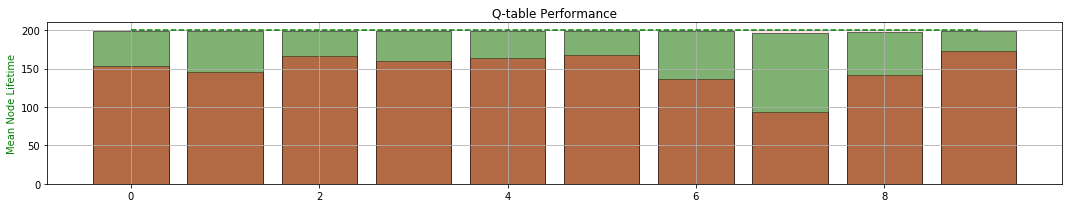

In [20]:
while iteration < MAX_NO_OF_ITERATIONS:

    print("\n")
    print("ITERATION #", iteration)
    tic = datetime.now()
    
    # MAP GYM ENVIRONMENT TO EACH PROCESS IN THE POOL
    ##################################################################
    q_table_list = [node_q_table]* NO_OF_NODES
    iter_list = [iteration] * NO_OF_NODES
    arg_list = [arg for arg in zip(range(NO_OF_NODES), node_boundaries, iter_list, q_table_list)]
    result   = pool.starmap(mp_node_run, arg_list)
    ##################################################################
    
    # GATHER RESULTS
    ##################################################################
    node_boundaries = np.array([item[2] for item in result])
    node_time_rec   = np.array([item[1] for item in result])
    node_exp        = np.array([item[0] for item in result])
    
    all_exp         = np.array([item for each_node_exp in node_exp 
                                    for episode_exp in each_node_exp 
                                    for item in episode_exp]).reshape(-1,N_STATES*2+2)
    total_parallel_timesteps += node_time_rec.max()
    total_serial_timesteps   += node_time_rec.sum()
    EXP_GEN = node_time_rec.sum().astype(int)
    
    print("TOTAL EXPERIENCE GENERATED:   {:d}".format(EXP_GEN.astype(int)))

    print("SMALLEST TIMESTEP: {:d}".format(node_time_rec.min().astype(int)))
    print("LARGEST  TIMESTEP: {:d}".format(node_time_rec.max().astype(int)))

    print("TOTAL SERIAL TIMESTEPS:   {:d}".format(total_serial_timesteps.astype(int)))
    print("TOTAL PARALLEL TIMESTEPS: {:d}".format(total_parallel_timesteps.astype(int)))
    ##################################################################

    # PLOT EXPERIENCES
    ##################################################################
    node_avg_time = node_time_rec.mean(axis=1)
    node_std_time = node_time_rec.std(axis=1)
    node_max_time = node_time_rec.max(axis=1)
    node_min_time = node_time_rec.min(axis=1)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    ax2.set_title("Q-table Performance")
    ax2.bar(range(NO_OF_NODES) , node_max_time, alpha = 0.1, color = 'r', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_avg_time, alpha = 0.5, color = 'g', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_min_time, alpha = 0.4, color = 'r', edgecolor = 'black', capsize=7 )

    ax2.plot(np.ones_like(node_avg_time)*200, 'g--')
    ax2.set_ylabel('Mean Node Lifetime',color = 'g')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    if node_avg_time[node_avg_time >= 195].shape[0] > NO_OF_NODES/2:
        final_result = "SUCCESS"
        break

    # SEGREGATE AND STORE EXPERIENCES
    ##################################################################
    dqn.memory = np.insert(dqn.memory,0,all_exp,0)
    dqn.memory = dqn.memory[:MIN_MEMORY_CAP,:]
    dqn.memory_counter += all_exp.shape[0]
#     good_mem = all_exp[all_exp[:,N_STATES+1] == 1]    
#     bad_mem  = all_exp[all_exp[:,N_STATES+1] < 1]


#     dqn.good_memory = np.insert(dqn.good_memory, 0, good_mem , 0)
#     dqn.good_memory_counter += good_mem.shape[0]

#     dqn.bad_memory  = np.insert(dqn.bad_memory, 0, bad_mem , 0)
#     dqn.bad_memory_counter += bad_mem.shape[0]

#     dqn.good_memory = dqn.good_memory[:MIN_MEMORY_CAP,:]
#     dqn.bad_memory = dqn.bad_memory[:MIN_MEMORY_CAP,:]

    NN_ITERATIONS = MAX_NN_ITERATIONS
    print("MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.memory_counter))

#     print("GOOD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.good_memory_counter))
#     print("BAD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.bad_memory_counter))
    ##################################################################

    # LEARN
    ##################################################################
    print("Training Neural Network for", NN_ITERATIONS, "iterations", "@ LR = ", NN_LR)
    tic=datetime.now()
    nn_level_up_metric = 0
    for nn_iter in range(NN_ITERATIONS):
        dqn.learn()
        #validate by running for TIMESTEP_LIMIT iterations
        if(nn_iter%int(NN_ITERATIONS/5) == int(NN_ITERATIONS/5)-1):
            print("\nValidating... ",end="")
            time_rec = []
            for i_episode in range(TIMESTEP_LIMIT):
                time_step = 0
                s = v_env.reset()

                while True:
                    time_step += 1 
                    a = dqn.choose_greedy_action(s)
                    s_, r, done, info = v_env.step(a)

                    if done:
                        break
                    s = s_
                time_rec = np.append(time_rec, time_step)
            mean_time = time_rec.mean()
            print("MEAN TIME: ", mean_time)
            if mean_time >= nn_level_up_metric:
                nn_level_up_metric = mean_time
                nn_level_up_metric = clamp(0, nn_level_up_metric, 195)
                torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

    print("TRAINING TIME:{}".format(datetime.now()-tic))
    ##################################################################

    # CHECK PERFORMANCE OF THE BEST MODEL
    ##################################################################
    best_dqn = D3QN()
    best_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
    best_dqn.eval_net.eval()

    time_rec = []
    for i_episode in range(TIMESTEP_LIMIT):
        time_step = 0
        s = env.reset()

        while True:
    #         env.render()
            time_step += 1 
            a = best_dqn.choose_greedy_action(s)
            s_, r, done, info = env.step(a)
            if done:
                break
            s = s_
        time_rec = np.append(time_rec, time_step)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    data = time_rec
    ax2.plot(data, color = 'm')
    ax2.plot(np.ones_like(data)*200, 'm--')
    ax2.set_title('Neural Network Performance using BEST MODEL ')
    ax2.set_ylabel('Time Steps',color = 'm')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    
    
        
    ##################################################################
    
    # CREATE ONE LARGE Q-TABLES FROM WHICH THE NODES STRIP
    ##################################################################
        
#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN * NO_OF_NODES  ])
    
    start = timeit.default_timer()
    # GET Q-VALUES 
    %memit node_q_table = best_dqn.get_greedy_action(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN).astype(np.intp)

    # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
    stop = timeit.default_timer()

#     ##################################################################
    
#     # CREATE INDIVIDUALIZED Q-TABLES FOR THE NODES
#     ##################################################################
    
    for node_id in range(NO_OF_NODES):
# #         # SET STATE VALUE BORDERS AS REQUESTED BY THE NODE
# #         ###############################################
#         [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
#          C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = node_boundaries[node_id]
# #         ###############################################
        print(node_id,'-max-',node_boundaries[node_id][:N_STATES])
        print(node_id,'-min-',node_boundaries[node_id][N_STATES:])
        print("")
        
# #         node_boundaries[node_id] = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_MAX,
# #                                     C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_MIN]
# #         # CREATE STATE COMBINATIONS
# #         ###############################################

#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])
#         ###############################################
#     start = timeit.default_timer()
#     # GET Q-VALUES 
#     %memit node_q_table = best_dqn.get_qvals(node_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1).astype(np.float16)

#     # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
#         #############################################################################################################################################
#     stop = timeit.default_timer()
    print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    iteration += 1
pool.close()
pool.join()

In [21]:
print("Total Parallel Timesteps : ", total_parallel_timesteps)
print("Total Serial Timesteps   : ", total_serial_timesteps)
print("Speed-up                 :  {:6.2f}".format(total_serial_timesteps/total_parallel_timesteps))

Total Parallel Timesteps :  866.0
Total Serial Timesteps   :  656188.0
Speed-up                 :  757.72


In [22]:
pool.close()
pool.join()
if iteration == MAX_NO_OF_ITERATIONS:
    final_result = "FAILURE"

In [23]:
print("{:6d} {} {:3d} {:3d} {:7d} {:10d} {:10.2f}".format(seed, final_result, int(node_min_time.min()), int(iteration), int(total_parallel_timesteps), int(total_serial_timesteps), total_serial_timesteps/total_parallel_timesteps))

  4507 SUCCESS  93   4     866     656188     757.72
